# Keras에서 데이터 증강을 사용한 Training
Cifar10 image 분류기를 처음부터 훈련하고 데이터 증강이 얼마나 많은 이점을 가져올 수 있는지 확인할 것입니다.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import time

그리고 데이터 세트의 처음 몇 개 이미지를 표시하는 도우미 함수를 정의할 것입니다.

In [2]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    for i in range(21):
        plt.subplot(3, 7, i+1)
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.title(class_names[class_index])
        plt.xticks([])
        plt.yticks([])
    plt.show()

## Cifar10 데이터 세트 로드  
Cifar10 데이터 세트를 가져오고 해당 클래스와 함께 몇 가지 이미지를 플로팅해 봅니다.

170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


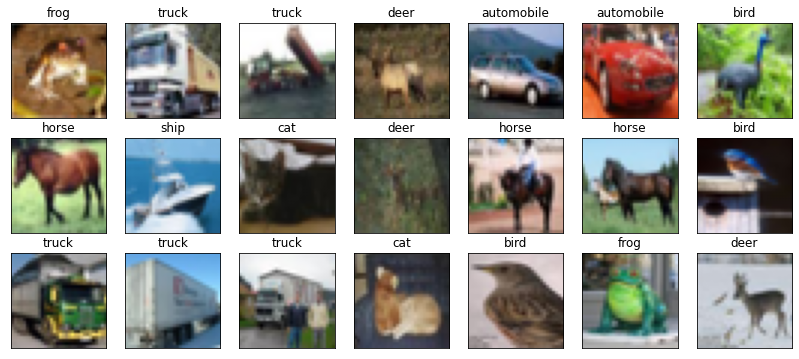

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train = X_train / 255.0
y_train = to_categorical(y_train, 10)

X_test = X_test / 255.0
y_test = to_categorical(y_test, 10)

visualize_data(X_train, y_train, class_names)

## Model Train

## 모델 정의
VGG 스타일의 합성곱 신경망 분류기를 생성하는 함수를 만듭니다.

- VGG 스타일
    - 3 x 3 필터로 두 차례 컨볼루션을 하는 것과 5 x 5 필터로 한 번 컨볼루션을 하는 것이 결과적으로 동일한 사이즈의 특성맵을 산출
    - 3x3 필터가 두개면 18개의 가중치이고 5x5 필터 한개는 25개의 가중치인데, CNN에서 가중치는 모두 훈련이 필요한 것들이므로, 가중치가 적다는 것은 그만큼 훈련시켜야할 것의 갯수가 작아진다. 따라서 학습의 속도가 빨라진다. 

In [4]:
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D((2,2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',))
    model.add(layers.MaxPool2D((2,2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',))
    model.add(layers.MaxPool2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## 데이터 증강 없이 훈련

데이터 증강 후의 모델과 비교하기 위해 데이터 증강 없이 Train

In [5]:
model_no_aug = create_model()
model_no_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [6]:
s = time.time()

batch_size = 32
epochs = 16

history_no_aug = model_no_aug.fit(
            X_train, y_train,
            epochs=epochs, batch_size=batch_size,
            validation_data=(X_test, y_test))

loss_no_aug, acc_no_aug = model_no_aug.evaluate(X_test,  y_test)

Epoch 1/16
1563/1563 [==============================] - 19s 6ms/step - loss: 1.5338 - accuracy: 0.4366 - val_loss: 1.1764 - val_accuracy: 0.5730
Epoch 2/16
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0365 - accuracy: 0.6296 - val_loss: 0.9472 - val_accuracy: 0.6677
Epoch 3/16
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8095 - accuracy: 0.7150 - val_loss: 0.8824 - val_accuracy: 0.7007
Epoch 4/16
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6738 - accuracy: 0.7633 - val_loss: 0.7718 - val_accuracy: 0.7336
Epoch 5/16
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5629 - accuracy: 0.8027 - val_loss: 0.7581 - val_accuracy: 0.7506
Epoch 6/16
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4796 - accuracy: 0.8298 - val_loss: 0.8169 - val_accuracy: 0.7425
Epoch 7/16
1563/1563 [==============================] - 9s 6ms/step - loss: 0.4017 - accuracy: 0.8574 - val_loss: 0.7991 - val_accuracy

In [7]:
print(f"경과 시간(분) :", (time.time() - s) / 60)

경과 시간(분) : 2.649785514672597


## Data Augmentation 정의
이제 데이터 증강 파이프라인을 설정하고 몇 가지 증강 이미지를 표시합니다.

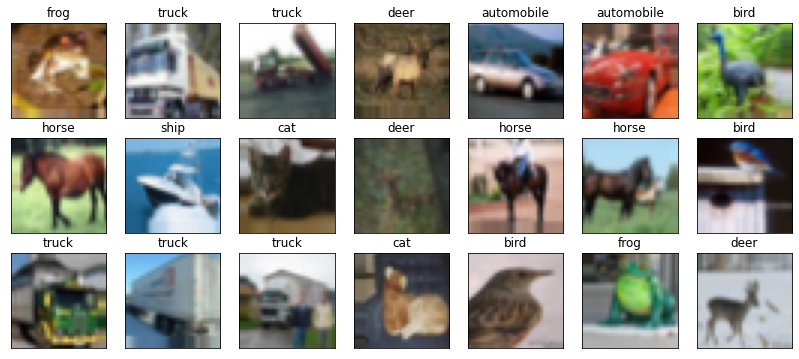

In [8]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
datagen.fit(X_train)

gen = datagen.flow(X_train, y_train, shuffle=False)
batch_images, batch_labels = next(gen)
visualize_data(batch_images, batch_labels, class_names)

## Data Augmentation을 이용한 Train

In [9]:
s = time.time()
model_aug = create_model()

history_aug = model_aug.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=(X_test, y_test))
loss_aug, acc_aug = model_aug.evaluate(X_test,  y_test)

Epoch 1/16
1563/1563 [==============================] - 31s 20ms/step - loss: 1.6234 - accuracy: 0.3993 - val_loss: 1.2664 - val_accuracy: 0.5439
Epoch 2/16
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1818 - accuracy: 0.5752 - val_loss: 1.0762 - val_accuracy: 0.6202
Epoch 3/16
1563/1563 [==============================] - 27s 18ms/step - loss: 0.9889 - accuracy: 0.6523 - val_loss: 0.9246 - val_accuracy: 0.6834
Epoch 4/16
1563/1563 [==============================] - 26s 16ms/step - loss: 0.8730 - accuracy: 0.6914 - val_loss: 0.7786 - val_accuracy: 0.7321
Epoch 5/16
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7933 - accuracy: 0.7231 - val_loss: 0.7691 - val_accuracy: 0.7370
Epoch 6/16
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7397 - accuracy: 0.7414 - val_loss: 0.7336 - val_accuracy: 0.7511
Epoch 7/16
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7046 - accuracy: 0.7542 - val_loss: 0.7544 -

In [10]:
print(f"경과 시간(분) :", (time.time() - s) / 60)

경과 시간(분) : 7.748562900225322


# Results
단일 plot에서 두 개 model을 비교

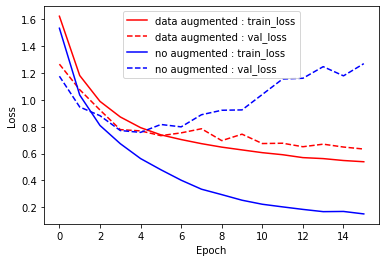

In [11]:
fig = plt.figure()

plt.plot(history_aug.history['loss'],
         label='data augmented : train_loss', c='red', ls='-')
plt.plot(history_aug.history['val_loss'],
         label='data augmented : val_loss', c='red',ls='--')

plt.plot(history_no_aug.history['loss'],
         label='no augmented : train_loss', c='blue', ls='-')
plt.plot(history_no_aug.history['val_loss'],
         label='no augmented : val_loss', c='blue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

augement된 data에 비해 no augmented data는 overfitting 이 심한 것을 알 수 있다. 즉, data augmentation 에 의해 model의 overfitting이 완화 되었다.